In [1]:
# Import necessary libraries for data manipulation and analysis
import numpy as np # Numerical operations
import pandas as pd # Data manipulation
from datetime import datetime, timedelta # Date operations

#Import necessary libraries for transformations
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats
from scipy.stats import skew, kurtosis

# Import libraries for plotting and visualization
import matplotlib.pyplot as plt # Matplotlib for basic plotting
import seaborn as sns # Seaborn for enhanced visualization
import plotly.express as px # Plotly for interactive plots

# Import libraries for time series analysis and modeling
from statsmodels.tsa.stattools import adfuller # Augmented Dickey-Fuller Test for stationarity check
from statsmodels.tsa.stattools import kpss # Kwiatkowski-Phillips-Schmidt-Shin Test for stationarity check
from statsmodels.tsa.statespace.sarimax import SARIMAX # SARIMAX model for time series forecasting
from statsmodels.tsa.seasonal import seasonal_decompose # Seasonal decomposition for trend, seasonal, and residual components
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima #SARIMAX using pmdarima

# Import necessary libraries for computing acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # For autocorrelation and partial autocorrelation plots
from statsmodels.tsa.stattools import acf, pacf  # For computing autocorrelation and partial autocorrelation

#Import libraries for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Import libraries for transformations
import joblib


In [2]:
import sys
sys.path.append(r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Final Codes\Day-Ahead\Try')
import SARIMAX

SARIMAX for Mindanao
DATA PREPROCESSING

In [3]:
#Import the necessary files
labels_csv = r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Mindanao\train_labels_transformed.csv'
data_csv = r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Mindanao\train_data_transformed.csv'
test_data_csv=r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Mindanao/test_data.csv'
test_labels_csv=r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Mindanao/test_labels.csv'
transformed_data=r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Mindanao/data_transformed.csv'
transformed_test=r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Mindanao/test_data_transformed.csv'
complete_data = r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Mindanao/MIN_Daily_Complete.csv'

transformed_train_data = pd.read_csv(data_csv)
transformed_train_labels = pd.read_csv(labels_csv)
transformed_data = pd.read_csv(transformed_data)
transformed_test_data = pd.read_csv(transformed_test)

test_data = pd.read_csv(test_data_csv)
test_labels = pd.read_csv(test_labels_csv)

complete_data_df = pd.read_csv(complete_data)
gwap = complete_data_df[['GWAP']]
lwap = complete_data_df[['LWAP']]

#80% train set, 20% test
train_size = int(len(transformed_train_labels))  
test_size = int(len(test_data))

date_range = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')
date_df = pd.DataFrame(date_range, columns=['Date'])

train_date = date_df[:train_size]
test_date = date_df[train_size:]

#Resetting the Index
train_date = train_date.reset_index(drop=True)
test_date = test_date.reset_index(drop=True)

In [4]:
#Preparing the dataframes
#Rename columns of complete transformed test dataframe
transformed_train_labels.rename(columns={'0': 'GWAP', '1': 'LWAP'}, inplace=True)
labels_columns = ['GWAP', 'LWAP']
labels_train = pd.DataFrame(transformed_train_labels, columns = labels_columns)
labels_test = pd.DataFrame(test_labels, columns = labels_columns)

#Rename columns of complete transformed dataframe
transformed_data.rename(columns={'0':'FLOW_MIN', '1':'Hourly Demand', '2':'TMIN_Davao City','3':'TMAX_Surigao','4':'TMIN_Surigao','5':'TMIN_Zamboanga','6':'TMIN_Butuan','7':'TMAX_Malaybalay','8':'TMAX_General Santos', '9':'GWAP', '10':'LWAP','11':'TMAX_Davao City','12':'TMAX_Zamboanga','13':'TMAX_Dipolog','14':'TMIN_Dipolog','15':'TMAX_Butuan','16':'TMIN_Malaybalay','17':'TMAX_Cotabato','18':'TMIN_Cotabato','19':'RESERVE_GWAP_Fr','20':'RESERVE_GWAP_Ru','21':'RESERVE_GWAP_Rd','22':'RESERVE_GWAP_Dr','23':'RAINFALL_Davao City','24':'RAINFALL_Surigao','25':'RAINFALL_Zamboanga','26':'RAINFALL_Dipolog','27':'RAINFALL_Butuan','28':'RAINFALL_Malaybalay','29':'RAINFALL_General Santos','30':'TMIN_General Santos','31':'RAINFALL_Cotabato'}, inplace=True)

#Define transformed dataset for test set GWAP and LWAP
transformed_test_data.rename(columns={'0':'FLOW_MIN', '1':'Hourly Demand', '2':'TMIN_Davao City','3':'TMAX_Surigao','4':'TMIN_Surigao','5':'TMIN_Zamboanga','6':'TMIN_Butuan','7':'TMAX_Malaybalay','8':'TMAX_General Santos', '9':'GWAP', '10':'LWAP','11':'TMAX_Davao City','12':'TMAX_Zamboanga','13':'TMAX_Dipolog','14':'TMIN_Dipolog','15':'TMAX_Butuan','16':'TMIN_Malaybalay','17':'TMAX_Cotabato','18':'TMIN_Cotabato','19':'RESERVE_GWAP_Fr','20':'RESERVE_GWAP_Ru','21':'RESERVE_GWAP_Rd','22':'RESERVE_GWAP_Dr','23':'RAINFALL_Davao City','24':'RAINFALL_Surigao','25':'RAINFALL_Zamboanga','26':'RAINFALL_Dipolog','27':'RAINFALL_Butuan','28':'RAINFALL_Malaybalay','29':'RAINFALL_General Santos','30':'TMIN_General Santos','31':'RAINFALL_Cotabato'}, inplace=True)
transformed_labels_test = pd.DataFrame(transformed_test_data, columns = labels_columns)

#Lag the transformed data
transformed_data = transformed_data.shift(1)
transformed_data = transformed_data.fillna(0)

#Remove GWAP and LWAP
transformed_exog = transformed_data.drop(columns=['GWAP','LWAP'])



Multicollinearity Test

In [5]:
%run SARIMAX.py
transformed_exog = remove_multicollinear(transformed_exog, 10)
calculate_vif(transformed_exog)

Dropping TMIN_General Santos with VIF of 57.12409525123147
Dropping TMIN_Cotabato with VIF of 44.5891900342407
Dropping Hourly Demand with VIF of 44.532535165964504
Dropping TMIN_Dipolog with VIF of 41.74318369426356
Dropping TMIN_Butuan with VIF of 36.93287581725218
Dropping TMAX_Surigao with VIF of 34.62963953005818
Dropping TMAX_General Santos with VIF of 34.18518938723088
Dropping TMAX_Malaybalay with VIF of 29.981772067604435
Dropping TMIN_Davao City with VIF of 26.49769034153409
Dropping TMAX_Dipolog with VIF of 21.372529360761213
Dropping TMIN_Zamboanga with VIF of 20.516312197969665
Dropping TMIN_Surigao with VIF of 16.888316416762866
Dropping TMIN_Malaybalay with VIF of 13.850669364066578
Dropping TMAX_Cotabato with VIF of 13.355180198487384
Dropping TMAX_Zamboanga with VIF of 11.826396545167254
Final VIF values:
                     feature       VIF
0                  FLOW_MIN  7.328797
1           TMAX_Davao City  9.456041
2               TMAX_Butuan  9.998546
3           R

,feature,VIF
0,FLOW_MIN,7.328797
1,TMAX_Davao City,9.456041
2,TMAX_Butuan,9.998546
3,RESERVE_GWAP_Fr,3.145611
4,RESERVE_GWAP_Ru,5.060148
5,RESERVE_GWAP_Rd,3.916398
6,RESERVE_GWAP_Dr,3.801823
7,RAINFALL_Davao City,3.868620
8,RAINFALL_Surigao,6.799650
9,RAINFALL_Zamboanga,5.266983


In [6]:
#Preparing transformed GWAP datasets
GWAP_train = labels_train['GWAP']
GWAP_train = pd.concat([train_date,GWAP_train], axis=1)
GWAP_train.set_index('Date', inplace=True)
GWAP_train.index = pd.to_datetime(GWAP_train.index)
GWAP_train = GWAP_train.squeeze()


GWAP_test = transformed_labels_test['GWAP']
GWAP_test = pd.concat([test_date,GWAP_test], axis=1)
GWAP_test.set_index('Date', inplace=True)
GWAP_test.index = pd.to_datetime(GWAP_test.index)
GWAP_test = GWAP_test.squeeze()

#Preparing original GWAP datasets
GWAP = pd.concat([date_df,gwap], axis=1)
GWAP.set_index('Date', inplace=True)
GWAP.index = pd.to_datetime(GWAP.index)
GWAP = GWAP.squeeze()

GWAP_test_inversed = GWAP[train_size:]


#Preparing the transformed LWAP datasets
LWAP_train = labels_train['LWAP']
LWAP_train = pd.concat([train_date,LWAP_train], axis=1)
LWAP_train.set_index('Date', inplace=True)
LWAP_train.index = pd.to_datetime(LWAP_train.index)
LWAP_train = LWAP_train.squeeze()

LWAP_test = transformed_labels_test['LWAP']
LWAP_test = pd.concat([test_date,LWAP_test], axis=1)
LWAP_test.set_index('Date', inplace=True)
LWAP_test.index = pd.to_datetime(LWAP_test.index)
LWAP_test = LWAP_test.squeeze()

#Preparing the original LWAP datasets

LWAP = pd.concat([date_df,lwap], axis=1)
LWAP.set_index('Date', inplace=True)
LWAP.index = pd.to_datetime(LWAP.index)
LWAP = LWAP.squeeze()

LWAP_test_inversed = LWAP[train_size:]

#Preparing the exog datasets
train_exog = transformed_exog[:train_size]
test_exog = transformed_exog[train_size:]

#Preparing the exogenous datasets
exog_train = pd.concat([train_date,train_exog], axis=1)
exog_train.set_index('Date', inplace=True)

test_exog = pd.DataFrame(test_exog)
test_exog = test_exog.reset_index()
exog_test = pd.concat([test_date,test_exog], axis=1)
exog_test.set_index('Date', inplace=True)
exog_test = exog_test.drop(columns=['index'])

In [7]:
#Applying the inverse transformations
#Loading inverse transformations for Mindanao

minmax_fit_loaded = joblib.load(r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Mindanao/minmax_scaler.pkl')
boxcox_fit_loaded = joblib.load(r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Mindanao/boxcox_pipeline.pkl')
yeojohnson_fit_loaded = joblib.load(r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Mindanao/yeojohnson_pipeline.pkl')
boxcoxy_fit_loaded = joblib.load(r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Mindanao/boxcox_pipeliney.pkl')

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PowerTransformer from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Jojie\A

In [8]:
#Plotting Train LWAP ang GWAP
# Create the line plot
gwap_plot = px.line(GWAP_train, x=GWAP_train.index, y='GWAP')
lwap_plot = px.line(LWAP_train, x=LWAP_train.index, y='LWAP')
# Set the title using the ticker value
gwap_plot.update_layout(title=f"Mindanao GWAP")
lwap_plot.update_layout(title=f"Mindanao LWAP")
# Display the plot
gwap_plot.show()
lwap_plot.show()

Differencing

In [8]:
%run SARIMAX.py

#Checking for stationarity in GWAP data
GWAP_train = perform_differencing(GWAP_train)
LWAP_train = perform_differencing(LWAP_train)

#Perform differencing on train exogenous data
diff_exog_train = perform_df_differencing(exog_train)
diff_exog_train = diff_exog_train.fillna(0)

#Perform differencing on test exogenous data
diff_exog_test = perform_df_differencing(exog_test)
diff_exog_test = diff_exog_test.fillna(0)

C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Final Codes\Day-Ahead\Updated 02-27\SARIMAX.py:57: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c')
C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Final Codes\Day-Ahead\Updated 02-27\SARIMAX.py:57: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c')
C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Final Codes\Day-Ahead\Updated 02-27\SARIMAX.py:85: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c')
C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Final Codes\Day-Ah

Data is stationary after differencing 0 times.
Data is stationary after differencing 0 times.
Column 'FLOW_MIN' is stationary after differencing 1 times.
Column 'TMAX_Davao City' is stationary after differencing 1 times.
Column 'TMAX_Butuan' is stationary after differencing 1 times.
Column 'RESERVE_GWAP_Fr' is stationary after differencing 1 times.
Column 'RESERVE_GWAP_Ru' is stationary after differencing 1 times.
Column 'RESERVE_GWAP_Rd' is stationary after differencing 1 times.
Column 'RESERVE_GWAP_Dr' is stationary after differencing 1 times.
Column 'RAINFALL_Davao City' is stationary after differencing 0 times.
Column 'RAINFALL_Surigao' is stationary after differencing 1 times.
Column 'RAINFALL_Zamboanga' is stationary after differencing 0 times.
Column 'RAINFALL_Dipolog' is stationary after differencing 1 times.
Column 'RAINFALL_Butuan' is stationary after differencing 1 times.
Column 'RAINFALL_Malaybalay' is stationary after differencing 1 times.
Column 'RAINFALL_General Santos' 

C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Final Codes\Day-Ahead\Updated 02-27\SARIMAX.py:85: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c')
C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Final Codes\Day-Ahead\Updated 02-27\SARIMAX.py:85: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c')
C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Final Codes\Day-Ahead\Updated 02-27\SARIMAX.py:85: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c')
C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Final Codes\Day-Ah

Order Specification

The ACF for GWAP is seen below
The PACF for GWAP is seen below


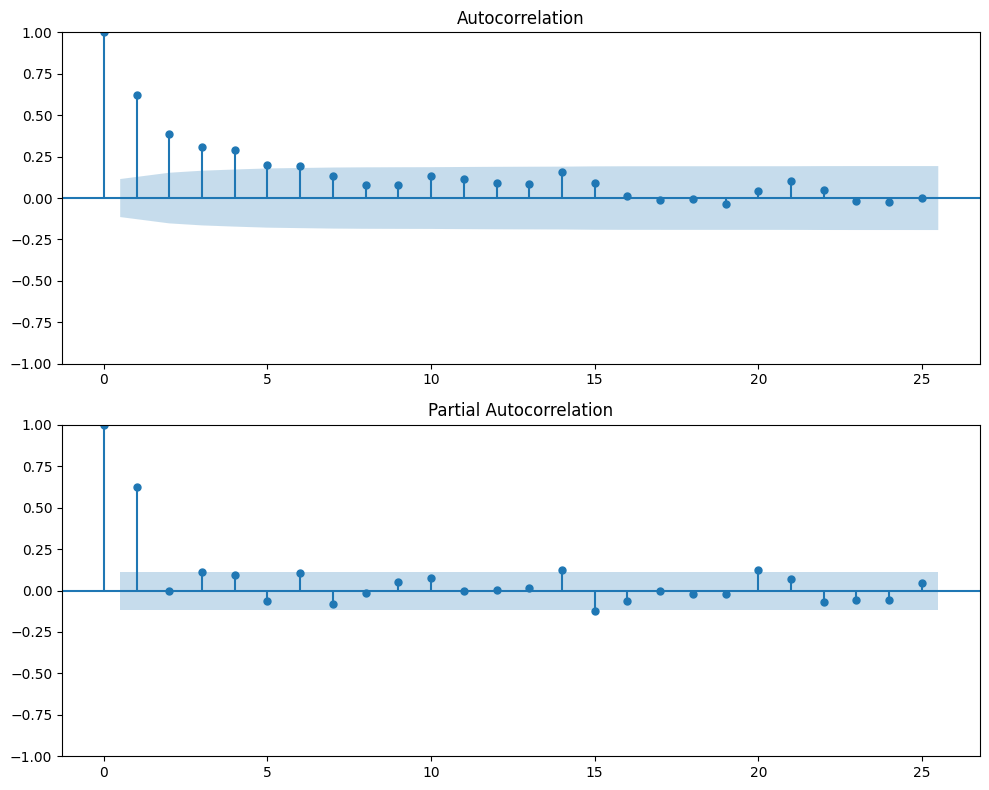

The ACF for LWAP is seen below
The PACF for LWAP is seen below


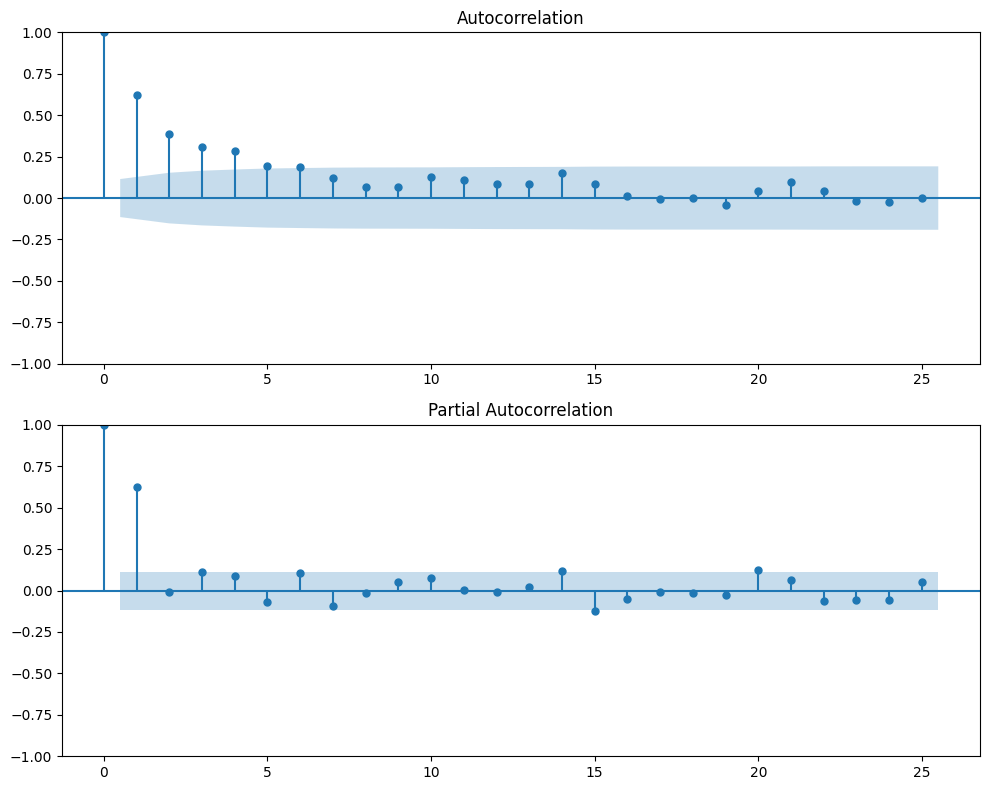

In [10]:
%run SARIMAX.py
# Get potential orders for GWAP
#Potential Orders for the AR terms is suggested by PACF
plot_orders(GWAP_train, lags=25, alpha=0.05, var='GWAP')
plot_orders(LWAP_train, lags=25, alpha=0.05, var='LWAP')

GWAP and LWAP Forecasting

In [26]:
%run SARIMAX.py
#Run seasonal_auto_arima function on GWAP 
#Use max_p and max_q based on acf and pacf plots
GWAP_sarimax = seasonal_auto_arima(GWAP_train, max_p=1, max_d=2, max_q=5, exog_data=diff_exog_train )

#Display results of previous function
GWAP_sarimax

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecatio

The model with the lowest AIC has a seasonal period of 7 and an AIC of -527.525965169074


ARIMA(maxiter=300, method='powell', order=(1, 0, 0), scoring_args={},
      seasonal_order=(2, 0, 1, 7), suppress_warnings=True)

In [27]:
%run SARIMAX.py
#Run seasonal_auto_arima function on GWAP 
#Use max_p and max_q based on acf and pacf plots
LWAP_sarimax = seasonal_auto_arima(LWAP_train, max_p=1, max_d=2, max_q=4, exog_data=diff_exog_train )

#Display results of previous function
LWAP_sarimax

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecatio

The model with the lowest AIC has a seasonal period of 7 and an AIC of -529.3599323640988


ARIMA(maxiter=300, method='powell', order=(1, 0, 0), scoring_args={},
      seasonal_order=(2, 0, 1, 7), suppress_warnings=True)

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: -0.941423
         Iterations: 19
         Function evaluations: 3473
                                      SARIMAX Results                                      
Dep. Variable:                                GWAP   No. Observations:                  292
Model:             SARIMAX(1, 0, 0)x(2, 0, [1], 7)   Log Likelihood                 274.896
Date:                             Wed, 05 Mar 2025   AIC                           -509.791
Time:                                     07:50:56   BIC                           -436.256
Sample:                                 01-01-2023   HQIC                          -480.336
                                      - 10-19-2023                                         
Covariance Type:                               opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: -0.943086
         Iterations: 19
         Function evaluations: 3473
                                      SARIMAX Results                                      
Dep. Variable:                                LWAP   No. Observations:                  292
Model:             SARIMAX(1, 0, 0)x(2, 0, [1], 7)   Log Likelihood                 275.381
Date:                             Wed, 05 Mar 2025   AIC                           -510.762
Time:                                     07:51:13   BIC                           -437.227
Sample:                                 01-01-2023   HQIC                          -481.307
                                      - 10-19-2023                                         
Covariance Type:                               opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

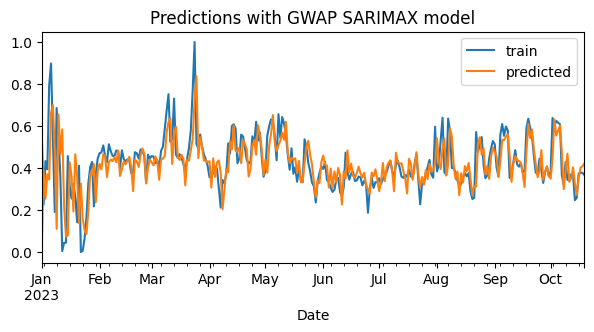

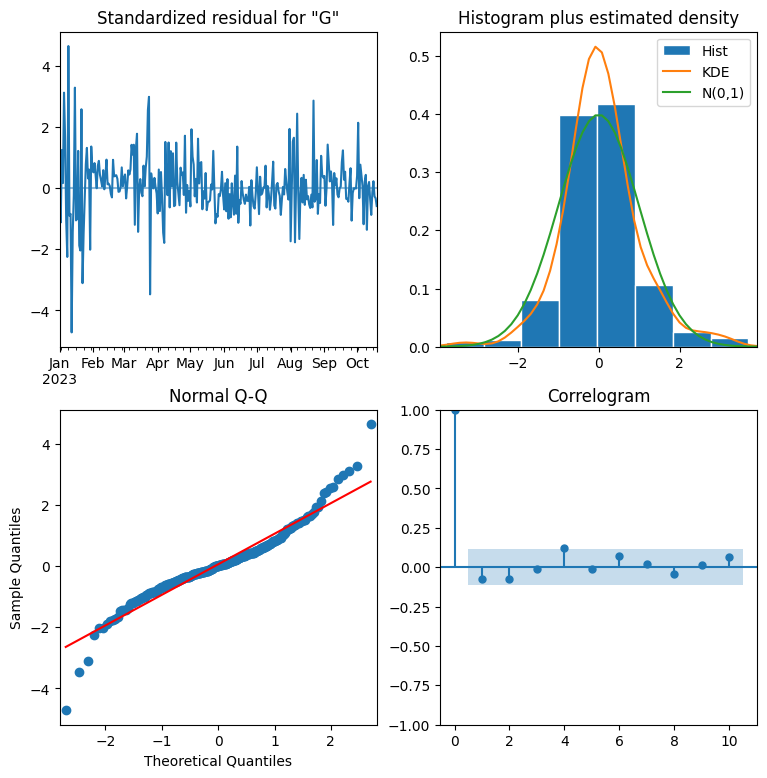

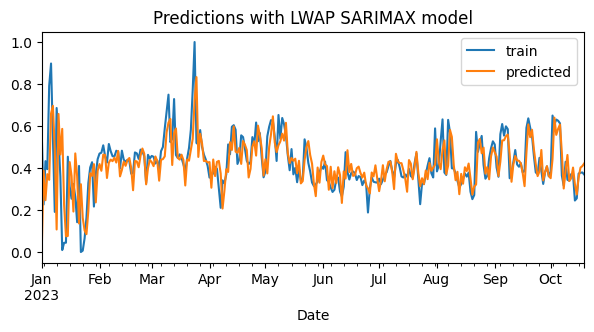

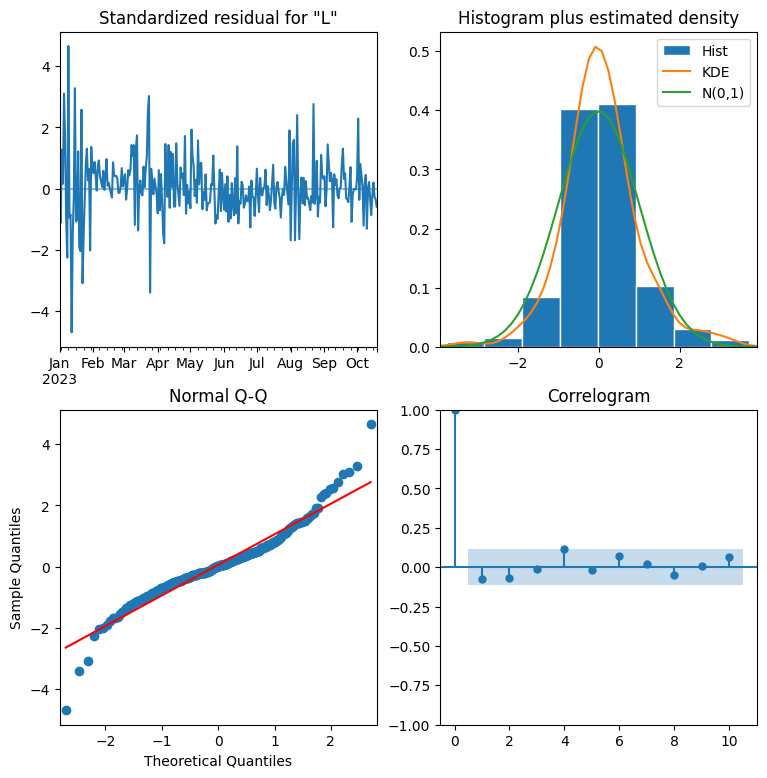

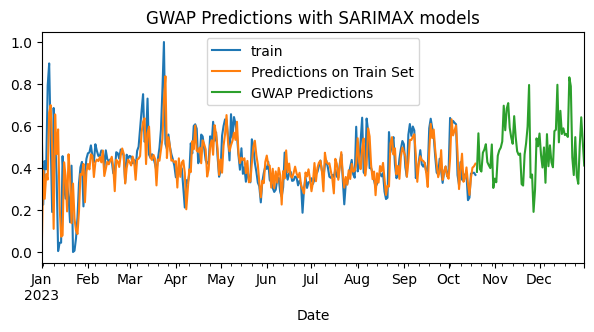

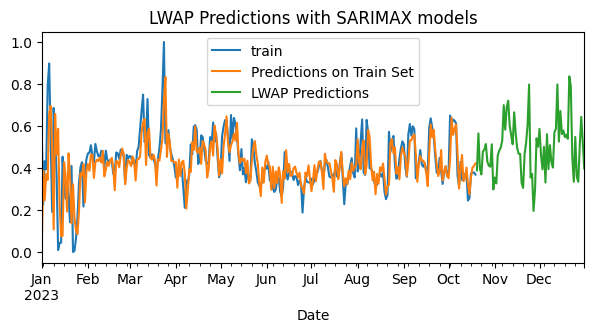

In [13]:
#Optimized orders for GWAP are (1,0,0)(2,0,1,7) and for LWAP are (1,0,0)(2,0,1)(7)
#This function fits the model and plots predictions on the train set; shows the summary of results and residuals diagnostics; and predicts on train set
%run SARIMAX.py

gwap_predictions, lwap_predictions = fit_SARIMAX(GWAP_train, LWAP_train, train_exog=diff_exog_train, gwap_order=(1,0,0), gwap_seasonal_order=(2,0,1,7), lwap_order = (1,0,0), lwap_seasonal_order=(2,0,1,7), GWAP_test=GWAP_test, LWAP_test=LWAP_test, exog_test = diff_exog_test)

Applying inverse transformations

In [14]:
%run SARIMAX.py 

GWAP_predictions_inverse, LWAP_predictions_inverse = inverse_predictions(gwap_predictions, lwap_predictions, boxcoxy_fit_loaded,test_date)


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


Mean Absolute Error (MAE) on Test Set for GWAP: 3033.4041774036245
Root Mean Squared Error (RMSE) on Test Set for GWAP: 3816.744749406821
Mean Absolute Percentage Error (MAPE) on Test Set for LWAP: 86.19189763281875


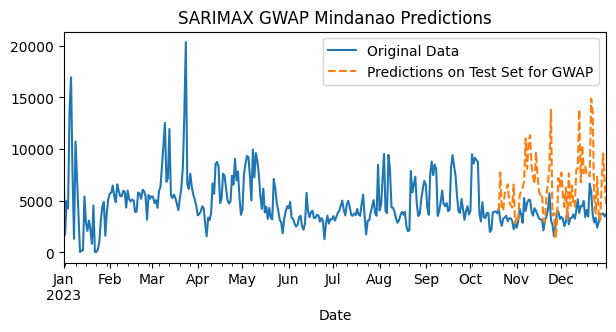

Mean Absolute Error (MAE) on Test Set for LWAP: 3215.4223007103087
Root Mean Squared Error (RMSE) on Test Set for LWAP: 4064.8673101629597
Mean Absolute Percentage Error (MAPE) on Test Set for LWAP: 86.96480311305572


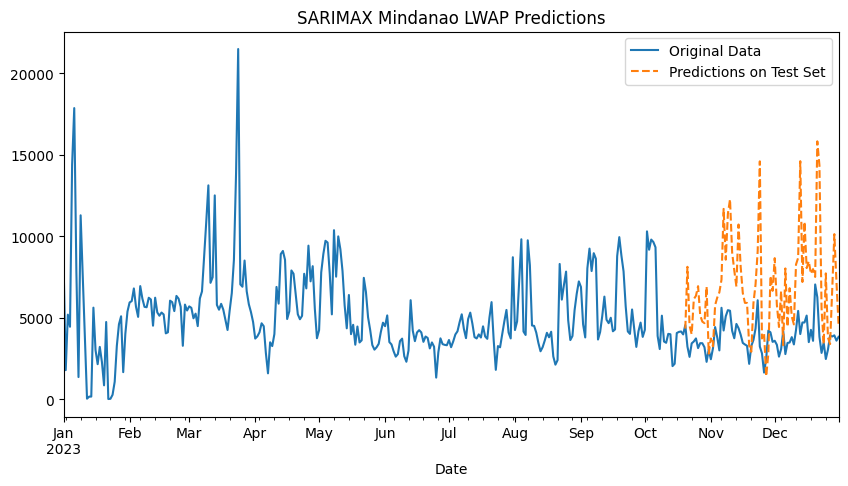

In [15]:
%run SARIMAX.py
evaluate_models(GWAP, LWAP, GWAP_test_inversed, GWAP_predictions_inverse, LWAP_test_inversed, LWAP_predictions_inverse, Region = 'Mindanao')


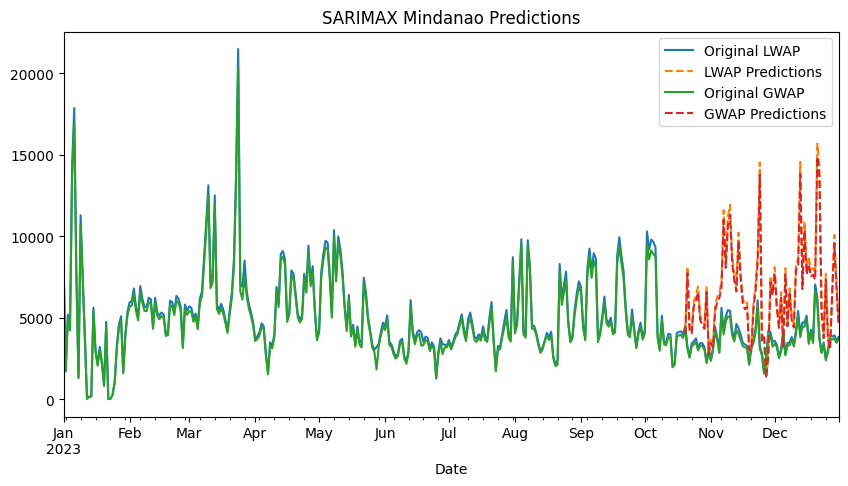

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
LWAP.plot(ax=ax, label='Original LWAP')
LWAP_predictions_inverse.plot(ax=ax, label='LWAP Predictions', linestyle='--')
GWAP.plot(ax=ax, label='Original GWAP')
GWAP_predictions_inverse.plot(ax=ax, label='GWAP Predictions', linestyle='--')
ax.set_title('SARIMAX Mindanao Predictions')
ax.legend()
plt.show()

In [15]:
GWAP_predictions_inverse.to_csv('min-gwap-predictions.csv', index=False)
LWAP_predictions_inverse.to_csv('min-lwap-predictions.csv', index=False)